In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns', None)

In [2]:
train = pd.read_csv('train_yaOffsB.csv')
test = pd.read_csv('test_pFkWwen.csv')
sub = pd.read_csv('sample_submission_O1oDc4H.csv')

train.head(3)

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1


In [3]:
train.shape, test.shape

((88858, 10), (59310, 9))

In [4]:
train['ID'].nunique(), test['ID'].nunique()

(88858, 59310)

In [5]:
train.describe()

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
count,88858.000000,88858.000000,88858.000000,88858.000000,88858.000000,79858.000000,88858.000000,88858.000000,88858.000000
mean,1399.012210,0.284375,0.458417,2.264186,25.849952,28.623970,9.589986,1.896959,0.190562
std,849.048781,0.451119,0.498271,0.461772,15.554428,12.391881,9.900631,0.701322,0.454215
min,150.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,731.000000,0.000000,0.000000,2.000000,15.000000,20.000000,0.000000,1.000000,0.000000
50%,1212.000000,0.000000,0.000000,2.000000,20.000000,28.000000,7.000000,2.000000,0.000000
75%,1898.000000,1.000000,1.000000,3.000000,40.000000,37.000000,16.000000,2.000000,0.000000
max,4097.000000,1.000000,1.000000,3.000000,95.000000,67.000000,50.000000,3.000000,2.000000


In [6]:
train.nunique()

ID                         88858
Estimated_Insects_Count       71
Crop_Type                      2
Soil_Type                      2
Pesticide_Use_Category         3
Number_Doses_Week             20
Number_Weeks_Used             64
Number_Weeks_Quit             51
Season                         3
Crop_Damage                    3
dtype: int64

In [7]:
# combine both train and test
df = pd.concat([train, test], ignore_index=True, sort=False)
print(df.shape)

(148168, 10)


> Feature Engineering --> Generating More Features

In [8]:
df.columns

Index(['ID', 'Estimated_Insects_Count', 'Crop_Type', 'Soil_Type',
       'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used',
       'Number_Weeks_Quit', 'Season', 'Crop_Damage'],
      dtype='object')

In [9]:
df['crop_type_insect_count_mean'] = df.groupby('Crop_Type')['Estimated_Insects_Count'].transform('mean')
df['crop_type_insect_count_std'] = df.groupby('Crop_Type')['Estimated_Insects_Count'].transform('std')
df['soil_type_insect_count_mean'] = df.groupby('Soil_Type')['Estimated_Insects_Count'].transform('mean')
df['soil_type_insect_count_std'] = df.groupby('Soil_Type')['Estimated_Insects_Count'].transform('std')
df['Pesticide_Use_Category_insect_count_mean'] = df.groupby('Pesticide_Use_Category')['Estimated_Insects_Count'].transform('mean')
df['Pesticide_Use_Category_insect_count_std'] = df.groupby('Pesticide_Use_Category')['Estimated_Insects_Count'].transform('std')
df['Number_Doses_Week_insect_count_mean'] = df.groupby('Number_Doses_Week')['Estimated_Insects_Count'].transform('mean')
df['Number_Doses_Week_insect_count_std'] = df.groupby('Number_Doses_Week')['Estimated_Insects_Count'].transform('std')
# df['Season_insect_count_mean'] = df.groupby('Season')['Estimated_Insects_Count'].transform('mean')
# df['Season_insect_count_std'] = df.groupby('Season')['Estimated_Insects_Count'].transform('std')


# Dummy Others
cols_2_dummy = ['Number_Weeks_Quit', 'Season']

df_dum = pd.get_dummies(data=df, columns=cols_2_dummy)
print(df.shape)
print(df_dum.shape)

# Drop ID column
cols_2_drop = ['ID']
df_dum.drop(cols_2_drop, axis=1, inplace=True)
print(df_dum.shape)

# Standardized the Data and Return to DataFrame

# ## To be done later to further imporove model if need be..
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()


(148168, 18)
(148168, 70)
(148168, 69)


> Get Train and Test Data

In [10]:
train = df_dum[df_dum['Crop_Damage'].isna() == False]
test = df_dum[df_dum['Crop_Damage'].isna() == True]
test.drop('Crop_Damage', axis=1, inplace=True)

X = train.drop('Crop_Damage', axis=1)
y = train['Crop_Damage']

# Apply Standardization
X_sc = sc.fit_transform(X)
test = sc.transform(test)

> Build CV 

In [11]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

err = []
y_pred_totcb = []
kfold = KFold(n_splits=5, random_state=2001)
for train_index, test_index in kfold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
    
    m1 = CatBoostClassifier(iterations=10000, learning_rate=0.01, eval_metric='Accuracy',
                            random_state=110)
    m1.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
           early_stopping_rounds=300, verbose=1000)
    preds = m1.predict(X_test)
    print('err:', accuracy_score(y_test, preds))
    err.append(accuracy_score(y_test, preds))
    p2 = m1.predict(test)
    y_pred_totcb.append(p2)
np.mean(err)

0:	learn: 0.8405875	test: 0.8405875	test1: 0.8395228	best: 0.8395228 (0)	total: 178ms	remaining: 29m 38s
1000:	learn: 0.8463692	test: 0.8463692	test1: 0.8450371	best: 0.8451497 (989)	total: 1m 17s	remaining: 11m 34s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.8455998199
bestIteration = 1085

Shrink model to first 1086 iterations.
err: 0.845599819941481
0:	learn: 0.8398982	test: 0.8398982	test1: 0.8421675	best: 0.8421675 (0)	total: 130ms	remaining: 21m 39s
1000:	learn: 0.8459753	test: 0.8459753	test1: 0.8480194	best: 0.8480194 (992)	total: 1m 17s	remaining: 11m 33s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.8480193563
bestIteration = 992

Shrink model to first 993 iterations.
err: 0.8480193562907945
0:	learn: 0.8410939	test: 0.8410939	test1: 0.8374972	best: 0.8374972 (0)	total: 82.8ms	remaining: 13m 47s
1000:	learn: 0.8470726	test: 0.8470726	test1: 0.8436304	best: 0.8436867 (998)	total: 1m 17s	remaining: 11m 34s
2000:	learn: 0.8497735	t

0.8455400554276983

In [14]:

err2 = []
y_pred_totcb2 = []
kfold = KFold(n_splits=5, random_state=2001)
X = pd.DataFrame(X_sc)
test = pd.DataFrame(test)
for train_index, test_index in kfold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
    
    m2 = XGBClassifier(iterations=2000, learning_rate=0.01, random_state=110)
    m2.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
           early_stopping_rounds=300, verbose=500)
    preds = m2.predict(X_test)
    print('err:', accuracy_score(y_test, preds))
    err2.append(accuracy_score(y_test, preds))
    p2 = m2.predict(test)
    y_pred_totcb2.append(p2)
np.mean(err2)

[0]	validation_0-merror:0.159413	validation_1-merror:0.160477
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 300 rounds.
[99]	validation_0-merror:0.159413	validation_1-merror:0.160477
err: 0.8426176007202341
[0]	validation_0-merror:0.160144	validation_1-merror:0.157551
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 300 rounds.
[99]	validation_0-merror:0.160144	validation_1-merror:0.157551
err: 0.8424487958586541
[0]	validation_0-merror:0.158906	validation_1-merror:0.162503
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 300 rounds.
[99]	validation_0-merror:0.158906	validation_1-merror:0.162503
err: 0.8374971865856403
[0]	validation_0-merror:0.159692	validation_1-merror:0.159361

0.8416575030827398

In [15]:

err3 = []
y_pred_totcb3 = []
kfold = KFold(n_splits=5, random_state=2001)
for train_index, test_index in kfold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
    
    m3 = LGBMClassifier(iterations=10000, learning_rate=0.2, random_state=110)
    m3.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
           early_stopping_rounds=300, verbose=1000)
    preds = m3.predict(X_test)
    print('err:', accuracy_score(y_test, preds))
    err3.append(accuracy_score(y_test, preds))
    p3 = m3.predict(test)
    y_pred_totcb3.append(p3)
np.mean(err3)

Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.379345	valid_1's multi_logloss: 0.422424
err: 0.8467251856853477
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.379211	valid_1's multi_logloss: 0.421199
err: 0.8490884537474679
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.376469	valid_1's multi_logloss: 0.42581
err: 0.8431802835921675
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.378846	valid_1's multi_logloss: 0.421447
err: 0.8464352034213044
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.378108	valid_1's mult

0.8466767318223732

> Make Submission

In [16]:
predict1 = np.mean(y_pred_totcb, 0)
predict2 = np.mean(y_pred_totcb2, 0)
predict3 = np.mean(y_pred_totcb3, 0)

a = {'Crop_Damage': (predict1)}
b = {'Crop_Damage': (predict2)}
c = {'Crop_Damage': (predict3)}

# sub1 = pd.DataFrame(data=a)
# sub2 = pd.DataFrame(data=b)
# sub3 = pd.DataFrame(data=c)

In [19]:
sub['Crop_Damage'] = predict2
sub.to_csv('sub1.csv', index=False)

In [20]:
fi = pd.Series(index=X.columns, data=m2.feature_importances_, name='feature_importance')
fi = fi.sort_values(ascending=False)
fi.head(10)

11    0.401903
3     0.186637
5     0.136458
12    0.120770
0     0.099302
1     0.034119
4     0.017880
67    0.002931
59    0.000000
58    0.000000
Name: feature_importance, dtype: float32

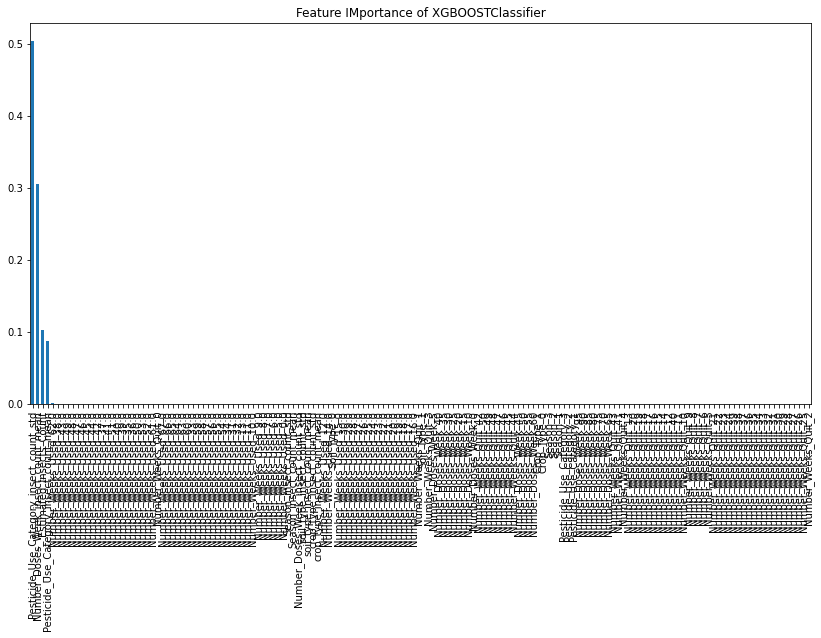

In [34]:
fi.plot(kind='bar', figsize=(14, 7), title='Feature IMportance of XGBOOSTClassifier')
# plt.show()